In [14]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image
import pandas as pd
import plotly.express as px
from IPython import display

In [15]:
import selfsupmotion.zero_shot_pose as zsp
import selfsupmotion.geometry as geo
zsp.use_cupy = False
experiment = zsp.ExperimentHandlerFile("../output/pretrain_224_dataplus_smallerfeat")
#embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [16]:
matches = zsp.find_all_match_idx(experiment.embeddings, experiment.train_embeddings)

  0%|          | 0/60 [00:00<?, ?it/s]

Using GPU to compute matches!


100%|██████████| 60/60 [01:07<00:00,  1.12s/it]


In [17]:
idx=91
#points_2d, points_3d_query = zsp.get_points(info_df, idx)
#points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
#plane_center_query, plane_normal_query= zsp.get_plane(info_df, idx)

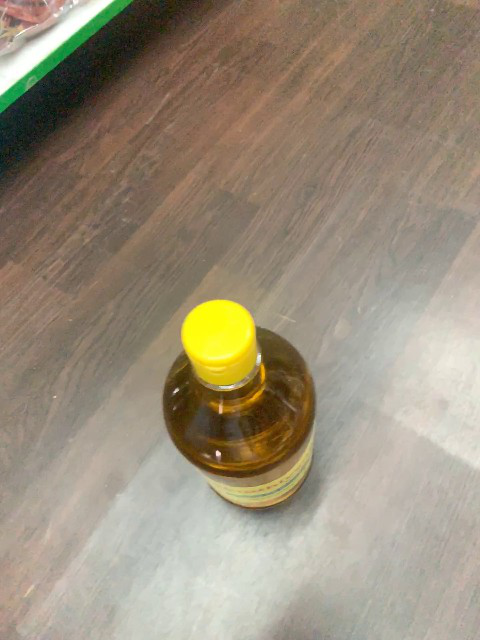

In [18]:
query_im=experiment.get_image(idx, train=False)
query_im

In [19]:
query_im.size

(480, 640)

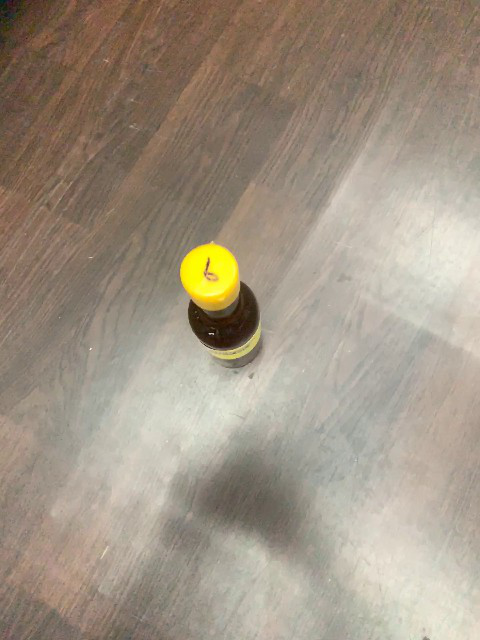

In [20]:
#match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
match_idx= matches[idx]
res_im=experiment.get_image(match_idx, train=True)
res_im

In [21]:
match_idx

225505

In [22]:
experiment.train_info_df.iloc[match_idx]

category_id                            2
uid                hdf5_bottle/01422_165
category                             NaN
sequence_uid                bottle/01422
frame                                NaN
video_id                             NaN
object_id                            NaN
batch_number                         NaN
sequence_number                      NaN
filepath                             NaN
filepath_full                        NaN
Name: 225505, dtype: object

In [23]:
experiment.info_df.iloc[idx]

category_id                            2
uid                hdf5_bottle/01304_145
category                             NaN
sequence_uid                bottle/01304
frame                                NaN
video_id                             NaN
object_id                            NaN
batch_number                         NaN
sequence_number                      NaN
filepath                             NaN
filepath_full                        NaN
Name: 91, dtype: object

In [24]:
#train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

In [25]:
from PIL import ImageDraw
points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)

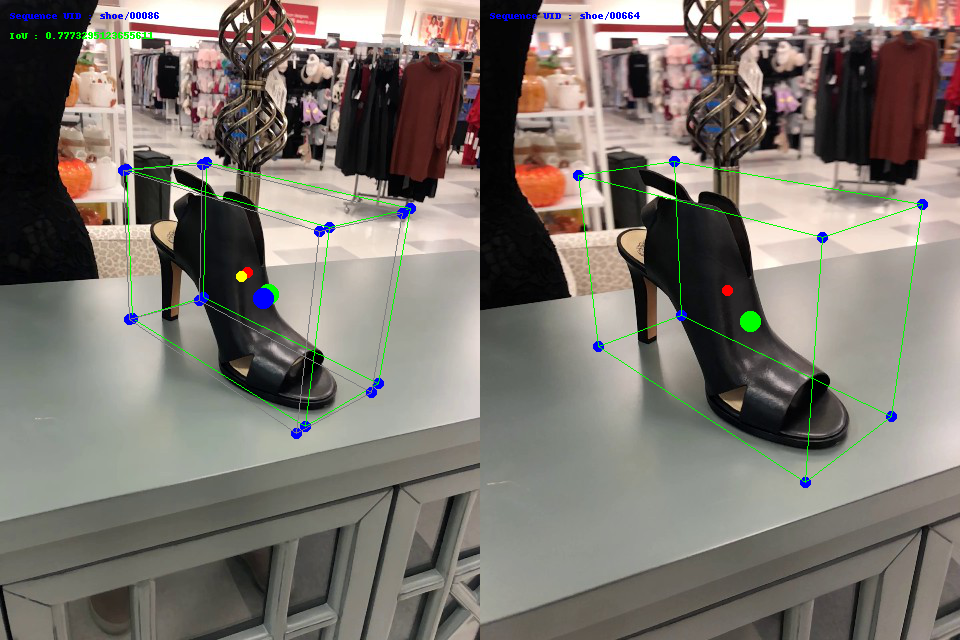

In [76]:
def get_preview(query_idx, match_idx):
    #query_im=Image.open(info_df.iloc[query_idx]["filepath_full"])
    canevas = Image.new('RGB', (480*2, 640))
    points_3d_result = zsp.get_bounding_box(query_idx, match_idx, experiment, adjust_scale=True)
    #points_3d_result=points_3d_result1
    query_im = experiment.get_image(query_idx, train=False)
    result_im = experiment.get_image(match_idx, train=True)
    #query_camera = zsp.get_camera(info_df, query_idx)
    query_intrinsics = experiment.get_intrinsics(query_idx, train=False)
    points_2d_query, points_3d_query = experiment.get_points(query_idx, train=False)
    points_2d_px_query = geo.points_2d_to_points2d_px(points_2d_query, 480, 640)
    
    points_2d_result_raw, points_3d_result_raw = experiment.get_points(match_idx, train=True)
    points_2d_px_result_raw = geo.points_2d_to_points2d_px(points_2d_result_raw, 480, 640)
    geo.draw_bbox(result_im,points_2d_px_result_raw)
    
    query_intrinsics = geo.scale_intrinsics(query_intrinsics, 1/3, 1/3)
    points2d_px_result = geo.project_3d_to_2d(points_3d_result, query_intrinsics)
    points2d_px_query = geo.project_3d_to_2d(points_3d_query, query_intrinsics)
    iou = zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))
    d = ImageDraw.Draw(query_im)
    iou_color = (255,0,0,255)
    if iou > 0.5:
        iou_color = (0,255,0,255)
    d.text((10,30),f"IoU : {iou}", fill=iou_color)
    
    query_sequence_uid = experiment.get_sequence_uid(query_idx, train=False)
    d.text((10,10),f"Sequence UID : {query_sequence_uid}", fill=(0,0,255,255))
    
    d = ImageDraw.Draw(result_im)
    result_sequence_uid = experiment.get_sequence_uid(match_idx, train=True)
    d.text((10,10),f"Sequence UID : {result_sequence_uid}", fill=(0,0,255,255))
    
    #print()
    geo.draw_bbox(query_im,points2d_px_result, line_color=iou_color)
    geo.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))
    canevas.paste(query_im)
    canevas.paste(result_im, (480,0))
    return canevas
display.display(get_preview(idx, match_idx))

In [77]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


slider = widgets.IntSlider(min=0, max=10000, step=1, value=10)

def f(x):
    idx =x 
    #match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
    match_idx = matches[idx]
    print(idx, match_idx)
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.display(get_preview(idx, match_idx))
interact(f, x=slider)


interactive(children=(IntSlider(value=10, description='x', max=10000), Output()), _dom_classes=('widget-intera…

<function __main__.f(x)>

In [160]:
experiment.info_df["sequence_uid"] = experiment.info_df["uid"].str.extract("hdf5_(\w+/\d+)_")
valid_sequences= sorted(list(experiment.info_df["sequence_uid"].unique()))
valid_sequence = valid_sequences[1009]
valid_sequence

'shoe/00203'

In [161]:
from natsort import natsorted
df = experiment.info_df.query(f"sequence_uid=='{valid_sequence}'")
df["idx"]=df.index
df = df.set_index("uid")
df = df.reindex(index=natsorted(df.index))


<ipython-input-161-2bc5cf0aedc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["idx"]=df.index


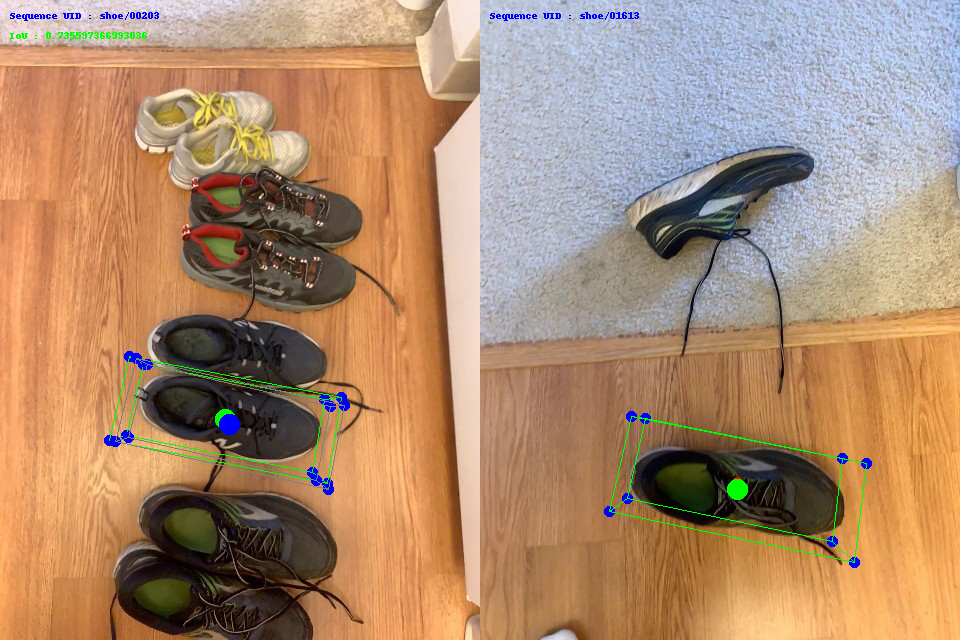

In [162]:
import time
idxs = list(df["idx"])
import cv2

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 5.0, (480*2,640))

for idx in idxs:
    match_idx = matches[idx]
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.clear_output(wait=True)
    preview_image = get_preview(idx, match_idx)
    display.display(preview_image)
    bgr_image = cv2.cvtColor(np.array(preview_image), cv2.COLOR_RGB2BGR)
    out.write(bgr_image)
    time.sleep(0.25)

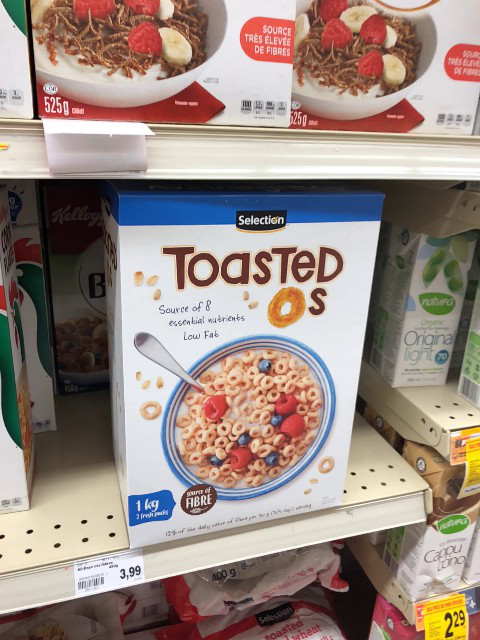

In [75]:
experiment.get_image(364121, train=True)

In [234]:
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"camera"], index=df.columns ), ignore_index=True)
    return df
points3d_df = build_df(points_3d_query, "query")
points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

0.43636998013146266

In [40]:
query_camera = zsp.get_camera(info_df, idx)

#result_camera = zsp.get_camera(train_info_df, train_idx)
#result_intrinsics = zsp.get_intrinsics(result_camera)
#result_intrinsics = zsp.scale_intrinsics(result_intrinsics, 0.25, 0.25)

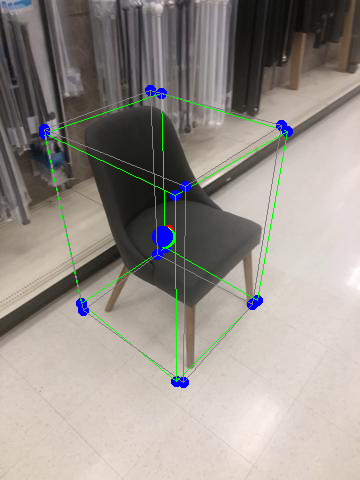

In [19]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [20]:

scale = zsp.get_bbox_area(query_bbox) / zsp.get_bbox_area(result_bbox)
scale

1.1055183682457537

In [21]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points_3d_result_centered, query_intrinsics, 2)
scale

1.052759184122877

In [22]:
points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
points3d_scaled

array([[-0.01861803, -0.04315793, -1.6003138 ],
       [ 0.31463464, -0.44888429, -1.84036112],
       [ 0.55302056, -0.01048551, -1.52644773],
       [-0.33932577, -0.44888345, -1.3437465 ],
       [-0.10094086, -0.01048463, -1.02983313],
       [ 0.06370481, -0.07583126, -2.17079547],
       [ 0.30208973,  0.36256757, -1.85688223],
       [-0.5902556 , -0.07583041, -1.67418085],
       [-0.35187069,  0.36256841, -1.36026761]])

In [23]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.7854928286905482

0 0.8131235878161949
1 0.8180783930713781
2 0.8191050178889032


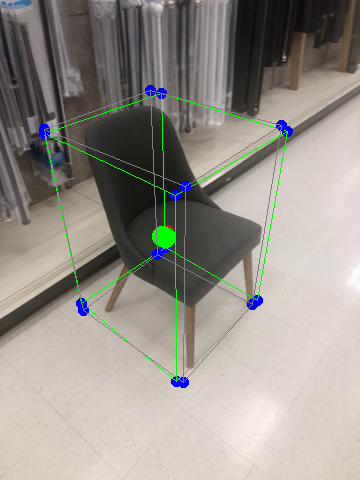

In [26]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
for i in range(0,3):
    obj_radius = zsp.get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
    print(i, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, query_intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, query_intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [27]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()